# Install Packages

In [1]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_v2_behavior()
print(tf.__version__)

import numpy as np

tf.get_logger().setLevel('ERROR')

2.15.0


Install TensorFlow Privacy.

In [2]:
!pip install tensorflow-privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ee72cb2e2dfb2dbcc9f5f816c7668210f7a526dd852dced421b2a517d769236e
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: 

In [3]:
!pip install imutils
from imutils import paths

# Mount Google Drive


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/kaggle/kaggleTrainingSet/trainingSet/trainingSet
mnist_path ='/content/drive/MyDrive/kaggle/kaggleTrainingSet/trainingSet/trainingSet'

0  1  2  3  4  5  6  7	8  9


# Create Clients

In [6]:
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

In [7]:
batch_size = 30
TOTAL_CLIENTS = 100
comms_round = 12

In [8]:

def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
#     random.shuffle(data)  # <- IID

    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients

    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

def batch_data(data_shard, bs=batch_size, flip=False):
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    data = np.array(data)

    labels = list(label)

    if flip:
        labels = shuffle(labels)

    labels = np.array(labels)
    data = np.array(list(data))

    assert(data.shape[0] == labels.shape[0])

#     data = tf.constant(data)
#     labels = tf.constant(labels)

    dataset = tf.data.Dataset.from_tensor_slices((data, labels))

    X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(data,
                                                    label,
                                                    train_size=0.9,
                                                    test_size=0.1,
                                                    random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((np.array(list(X_data_train)), np.array(list(y_data_train))))
    test_dataset = tf.data.Dataset.from_tensor_slices((np.array(list(X_data_test)), np.array(list(y_data_test))))
    return (train_dataset.shuffle(len(y_data_train)).batch(bs), test_dataset.batch(bs), y_data_test)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs


    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)

    return local_count/global_count

def fed_avg(weights):
    assert(len(weights) > 0)
    n_layers = len(weights[0])

    avg_weights = list()

    for layer in range(n_layers):
        layer_weights = np.array([w[layer] for w in weights])
        mean_layer_weights = np.mean(layer_weights, axis = 0)
        avg_weights.append(mean_layer_weights)

    return avg_weights



def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('round/client: {} | acc: {:.3%} | loss: {}'.format(comm_round, acc, loss))
    return acc, loss

# Create Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

class SimpleMLP:

    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes, use_bias=True, name="last_dense"))
        model.add(Activation("softmax"))
        return model


In [10]:
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [11]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28*28)
test_data = test_data.reshape(test_data.shape[0], 28*28)

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

train_data.shape, train_labels.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 784), (60000, 10))

In [12]:
X_train, X_test, y_train, y_test = train_data, test_data, train_labels, test_labels

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

In [14]:
clients = create_clients(X_train, y_train, num_clients=TOTAL_CLIENTS, initial='client')

In [15]:
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl size=11756942 sha256=3bb857c5bd6ea8f32c5d2c9120303e547f1dcbde3d20aeee9ddcd07fa0cb24a4
  Stored in directory: /root/.cache/pip/wheels/a7/83/5a/c704868d367ace343ac89b928f3d937313a5b5fb5731483705
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


# Heatmap of non-IID data

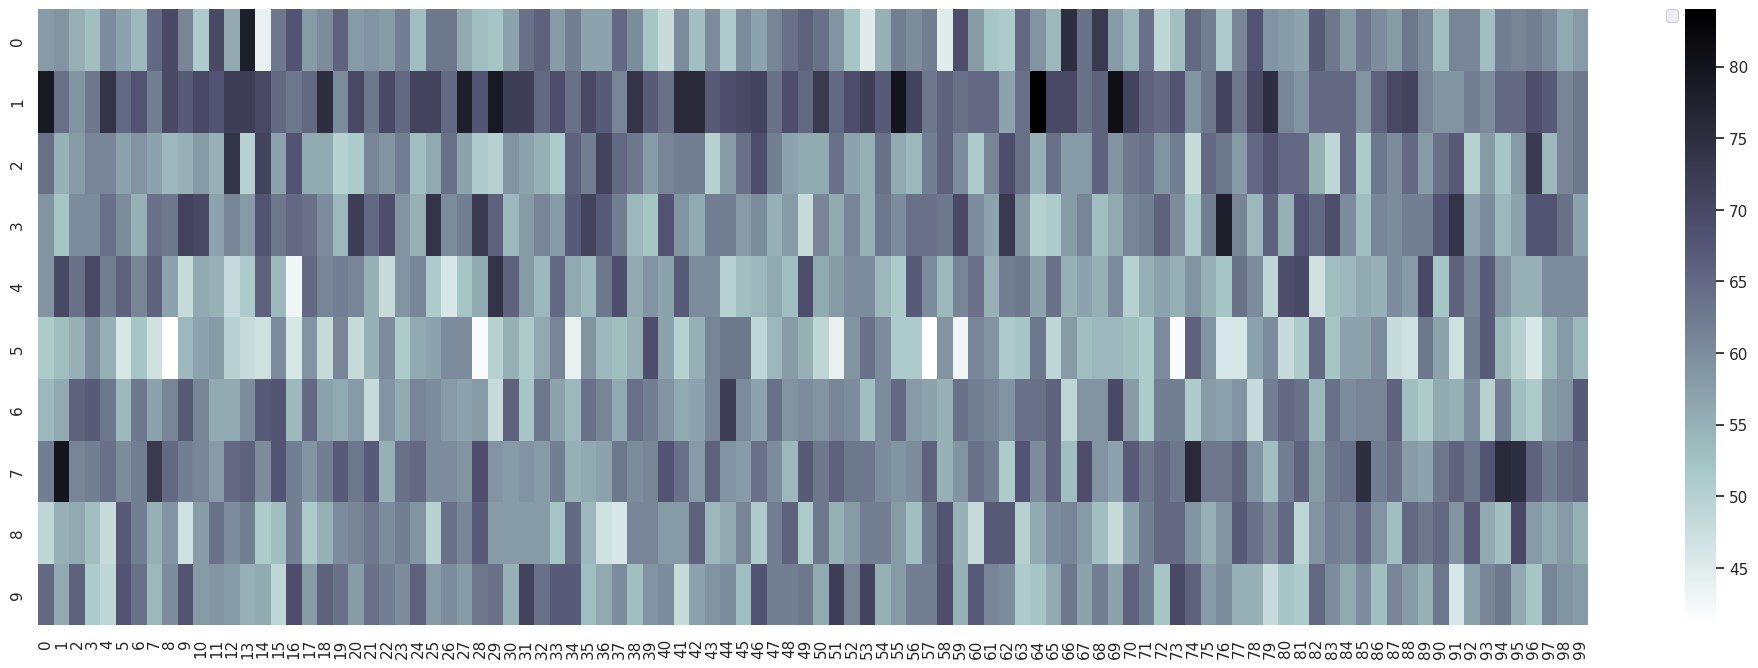

In [16]:
from collections import Counter
import seaborn as sns

def one_hot_to_numbers(labels):
    numbers = []
    for one_hot in labels:
        number = np.argmax(one_hot)
        numbers.append(number)
    return numbers

def number_count_tuples(numbers):
    count_dict = dict(Counter(numbers))
    count_tuples = [(number, count) for number, count in count_dict.items()]
    return count_tuples

distrib = [[0]*TOTAL_CLIENTS for _ in range(10)]
client_id = 0
for client_name in clients.keys():
    client_data = clients[client_name]
    _, labels = zip(*client_data)
    numbers = one_hot_to_numbers(labels)
    count_tuples = number_count_tuples(numbers)

    for item in count_tuples:
        distrib[item[0]][client_id] = item[1]

    client_id += 1

    distrib = np.array(distrib)
# print(distrib)
sns.set(rc={'figure.figsize':(25,8)})
sns.heatmap(distrib, cmap='bone_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
# plt.savefig("heatmap.png")

# Create byzantine participants

In [17]:
frac = 0.2
BYZANTINE_CNT = int(frac*TOTAL_CLIENTS)

In [18]:
import random
from sklearn.utils import shuffle

#process and batch the training data for each client
# and pick one owner that is not byzantine
client_names = list(clients.keys())
owner_idx = random.randint(0,len(client_names))
owner_name = client_names[owner_idx]

clients_batched = dict()
flipped = []
for (client_name, data) in clients.items():
    flip = True if client_name != owner_name and random.randint(0,TOTAL_CLIENTS) < BYZANTINE_CNT else False
    if flip:
        flipped.append(client_name)
    clients_batched[client_name] = batch_data(data, flip=flip)

print('flipped:', len(flipped))

#process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((np.array(list(X_test)), np.array(list(y_test)))).batch(len(y_test))

flipped: 17


In [19]:
PRIVATIZE = False

# FedAvg

In [20]:
# FedAvg for complete weights

def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''

    avg_grad = tf.math.reduce_sum(weight_list, axis=0)
    avg_grad = tf.multiply(layer_mean, 1/len(weight_list))

    return avg_grad

# Bias Detect

In [21]:
# Efficient Detection of Byzantine Attacks in
# Federated Learning using Last Layer Biases

from scipy.spatial.distance import cdist
from scipy.optimize import minimize

def get_distances_from_geomed(geomed, points):
    return cdist([geomed], points)

# median absolute deviation (MAD)
def compute_mad(update, update_length):
    m = np.median(update)
    mad = 0
    for i in range(update_length):
        mad+=abs(update[i]-m)

    return mad/update_length

def minimize_method(points, options={}):
    """
    Geometric median as a convex optimization problem. refers to the point in a multidimensional space that minimizes the sum of distances
    to a set of other points. It can be modeled as a convex optimization problem, where the objective function is the sum of distances
    from the candidate solution to the set of points, and the constraints are the bounds on the dimensions of the solution.
    """

    # objective function
    def aggregate_distance(x):
        return cdist([x], points).sum()

    # initial guess: centroid
    centroid = points.mean(axis=0)
#     print(centroid)

    optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

    return optimize_result.x


def weiszfeld_method(points, options={}):
    """
    Weiszfeld's algorithm as described on Wikipedia. It's a numerical method
    for finding the geometric median of a set of points in a Euclidean space.
    """

    default_options = {'maxiter': 1000, 'tol': 1e-7}
    default_options.update(options)
    options = default_options

    def distance_func(x):
        return cdist([x], points)

    # initial guess: centroid
    guess = points.mean(axis=0)

    iters = 0

    while iters < options['maxiter']:
        distances = distance_func(guess).T

        # catch divide by zero
        # TODO: Wikipedia cites how to deal with distance 0
        distances = np.where(distances == 0, 1, distances)

        guess_next = (points/distances).sum(axis=0) / (1./distances).sum(axis=0)

        guess_movement = np.sqrt(((guess - guess_next)**2).sum())

        guess = guess_next

        if guess_movement <= options['tol']:
            break

        iters += 1

    return guess


_methods = {
    'minimize': minimize_method,
    'weiszfeld': weiszfeld_method,
}

def geometric_median(points, method='auto', options={}):
    """
    Calculates the geometric median of an array of points.
    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    """

    points = np.asarray(points)

    if len(points.shape) == 1:
        # geometric_median((0, 0)) has too much potential for error.
        # Did the user intend a single 2D point or two scalars?
        # Use np.median if you meant the latter.
        raise ValueError("Expected 2D array")

    if method == 'auto':
        if points.shape[1] > 2:
            # weiszfeld tends to converge faster in higher dimensions
            method = 'weiszfeld'
        else:
            method = 'minimize'

    return _methods[method](points, options)


def get_honest_workers(distances_from_geomed):
    """
    the function sets the tolerance level to be 1.5 times the maximum value of the first m distances, where m is half of the number of workers plus one.
    This tolerance value is used to assign scores to the workers. If the distance between two consecutive workers is greater than the tolerance,
    the scores for the workers with higher distances are set to zero.

    The scores assigned to the workers are then sorted according to the original indices of the workers.
    A median of the distances from the geometric median is then computed, and workers with distances less than or equal to the median are assigned scores of 1.

    Finally, the function returns the indices of the workers who have scores of 1 and the list of scores for all workers as two separate outputs.
    """

    distances_from_geomed = np.asarray(distances_from_geomed)
    indices = distances_from_geomed.argsort()
    sorted_distances = np.asarray(sorted(distances_from_geomed))

    n = len(sorted_distances)
    between_distances = np.zeros(n)
    for i in range(1, n):
        between_distances[i] = sorted_distances[i]-sorted_distances[i-1]

    m = int(n/2)+1
    tolerance = max(between_distances[:m+1])*1.5
    scores = np.ones(n)
    for i in range(m, n):
        if between_distances[i] > tolerance:
            scores[i:] = 0
            break
    sorted_scores = np.empty_like(scores)

    for i, idx in enumerate(indices):
        sorted_scores[idx] = scores[i]

    scores = sorted_scores
    median = np.percentile(distances_from_geomed, [60])
    for i in range(n):
        if distances_from_geomed[i]<=median:
            scores[i] = 1

    honest_workers = [i for i, x in enumerate(scores) if x]

    return honest_workers, list(scores)

def assess_workers(client_layer_tuples):
    clients = [item[0] for item in  client_layer_tuples]
    last_layer_biases = [item[1][1] for item in  client_layer_tuples]
    # median absolute deviation (MAD)
    mad_biases = [compute_mad(last_layer_biases[i].flatten(), 10) for i in range(len(last_layer_biases))]
#     print('MAD biases', mad_biases)
    geomed = geometric_median(last_layer_biases, method='auto')
#     print('GeoMed ', geomed)
    distances_from_geomed = get_distances_from_geomed(geomed, last_layer_biases)[0]
#     print('Distances from geomed ', distances_from_geomed)
    honest_workers, scores = get_honest_workers(distances_from_geomed)
    honest_workers = [clients[i] for i in honest_workers]
    dishonest_workers = []

    for i in range(len(clients)):
        if scores[i] == 0:
            dishonest_workers.append(clients[i])

    return honest_workers, dishonest_workers, scores

# Multi-Krum

In [22]:
# Utils

def score(weights, trainers):
    R = len(weights)
    f = R // 3 - 1
    closest_updates = R - f - 2

    scores = []

    for i in range(len(weights)):
      dists = []

      for j in range(len(weights)):
        if i == j:
          continue

        diff = np.subtract(weights[j],weights[i])
        l2_norm = np.sqrt(np.sum([np.sum(np.square(w)) for w in diff]))
        dists.append(l2_norm)

      dists_sorted = np.argsort(dists)[:closest_updates]
      score = np.array([dists[i] for i in dists_sorted]).sum()
      scores.append(score)
    return trainers, scores

def _tra_score(weights, my_weights, other_trainers):
    R = len(weights)
    f = R // 3 - 1
    closest_updates = R - f - 2

    dists = []

    for i in range(len(weights)):
        diff = np.subtract(weights[i], my_weights)
        l2_norm = np.sqrt(np.sum([np.sum(np.square(w)) for w in diff]))
        dists.append(l2_norm)

    dists_sorted = np.argsort(dists)[:closest_updates]
    return [other_trainers[i] for i in dists_sorted]

def fed_avg(weights):
    assert(len(weights) > 0)
    n_layers = len(weights[0])

    avg_weights = list()

    for layer in range(n_layers):
        layer_weights = np.array([w[layer] for w in weights])
        mean_layer_weights = np.mean(layer_weights, axis = 0)
        avg_weights.append(mean_layer_weights)

    return avg_weights

def multikrum_selected_trainers(local_weight_tuples):

    weights = [item[1] for item in local_weight_tuples]
    trainers = [item[0] for item in local_weight_tuples]

    trainers, scores = score(weights, trainers)

    medians = []

    for t, trainer in enumerate(trainers):
      medians.append(np.median(scores[t]))

    R = len(weights)
    f = R // 3 - 1

    sorted_idxs = np.argsort(medians)
    lowest_idxs = sorted_idxs[:R-f]

    honest_trainers = []
    dishonest_trainers = []

    for i in range(len(trainers)):
        if i in lowest_idxs:
           honest_trainers.append(trainers[i])
        else:
           dishonest_trainers.append(trainers[i])

    return honest_trainers, dishonest_trainers, scores

# Bristle

In [23]:
# Bristle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from statistics import stdev
import math

def build_model():
  model = SimpleMLP.build(784, 10)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model



def freeze_all_except_out(model):
    for layer in global_model.layers[:-2]:
        layer.trainable=False

def unfreeze_all_layers(model):
    for layer in global_model.layers:
        layer.trainable=True

def get_last_dense_layer_weights(model):
    return model.get_weights()[-2]

def weight_sigmoid(omega1, omega2, disc, certainty):
    return max(0, omega1/(1 + math.exp(-disc/100)) - omega2)*certainty

def compute_fa_fo_wg(my_detailed_f1, detailed_f1, fi=10, mu=0.9, omega_fa1=0.99, omega_fa2=0.1, omega_fo1=0.5, omega_fo2=0.5):
    disc = [0]*len(my_detailed_f1)
    fa_wg = [0]*len(my_detailed_f1)
    fo_columns = [0]*len(my_detailed_f1)

    best = sorted(detailed_f1, reverse=True)[:fi]
    certainty = max(sum(best)/len(best) - stdev(best), 0) if len(best) > 0 else 0

    for c in range(len(my_detailed_f1)):
        if detailed_f1[c] > 0 and my_detailed_f1[c] == 0:
            fo_columns[c] == 1

        weighed_diff = (detailed_f1[c] - my_detailed_f1[c])*mu
        if detailed_f1[c] > my_detailed_f1[c]:
            disc[c] = weighed_diff**(3 + my_detailed_f1[c])
        else:
            disc[c] = -math.inf #-1*pow(weighed_diff, 4 + int(my_detailed_f1[c]))

        fa_wg[c] = weight_sigmoid(omega_fa1, omega_fa2, disc[c], certainty)

    fo_wg = weight_sigmoid(omega_fo1, omega_fo2, sum(disc), certainty)
    return fa_wg, fo_wg, fo_columns

def layers_weighted_average(my_layer, layer_list, fa_wg_list, fo_columns_list):
    class_cnt = len(my_layer[0])
    my_new_layer = copy.deepcopy(my_layer)
    total_weights = [1]*class_cnt
    for i in range(len(layer_list)):
        for c in range(class_cnt):
            my_new_layer[0][c] = my_layer[0][c] + layer_list[i][0][c]*fa_wg_list[i][c]
            total_weights[c] += fa_wg_list[i][c]

    for c in range(class_cnt):
        my_new_layer[0][c] = my_new_layer[0][c]/total_weights[c]

    return my_new_layer

In [24]:
def calc_F1(test_data_tf,  y_local_test, model, labels = [0,1,2,3,4,5,6,7,8,9], logits = None, fi=10):
    if logits == None:
        logits = model.predict(test_data_tf)

    detailed_f1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(y_local_test, axis=1), average=None, labels=labels, zero_division=1)
    f1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(y_local_test, axis=1), average='macro', labels=labels, zero_division=1)

    return f1, detailed_f1

In [25]:
def weighed_aggretate(weight_list, factors = []):
    if factors == []:
        factors = [1]*len(weight_list)

    for i in range(len(weight_list)):
        weight_list[i] = scale_model_weights(weight_list[i], factors[i]/sum(factors))

    return sum_scaled_weights(weight_list)

In [26]:
def local_train(client, global_model, local_model, local_rounds = 3, byzantine=False):
    if not byzantine:
        new_weights = copy.copy(global_model.get_weights())
        local_model.set_weights(new_weights)
    train_ds, test_ds, _ = clients_batched[client]
    local_model.fit(train_ds, epochs=local_rounds, verbose=False)

In [27]:
def has_foreign_classes(my_f1, other_f1):
    for i in range(len(my_f1)):
        if my_f1[i] == 0 and other_f1[i] > 0:
            return True
    return False

In [28]:
def local_rank(model, client_layer_tuples, test_data_tf, y_local_test, my_f1, my_detailed_f1, count = 10, min_f1 = .1, exclude_foreign_classes = False):
    f1_list = []
    f1_detailed_list = []
    layer_list = []
    client_list = []

    honest, dishonest, _ = assess_workers(client_layer_tuples)

    for client_tuple in client_layer_tuples:
        if client_tuple[0] in dishonest:
            continue

        model = reconstruct_model(model.get_weights(), client_tuple[1])
        f1, detailed_f1 = calc_F1(test_data_tf, y_local_test, model)

        if exclude_foreign_classes and has_foreign_classes(my_detailed_f1, detailed_f1):
            continue
        if f1 < min_f1:
            continue

        f1_list.append(f1)
        f1_detailed_list.append(detailed_f1)
        layer_list.append(layer)
        client_list.append(client_tuple[0])

#     indexes = sorted(range(len(f1_list)), key=lambda i: f1_list[i])[-count:]
    indexes = [i[0] for i in sorted(enumerate(f1_list), key=lambda x:x[1], reverse=True)] #[:-count]
    return [f1_list[x] for x in indexes], [f1_detailed_list[x] for x in indexes], [layer_list[x] for x in indexes], [client_list[x] for x in indexes]

# Utils

In [29]:
def reconstruct_model(base_model_weights, last_dense_layer):
    model = build_model()
    base_model_weights[-2] = np.array(last_dense_layer)
    model.set_weights(base_model_weights)
    return model

In [30]:
def integrate_classes_my_model(my_layer, client_layer_tuples, test_data_tf,  y_local_test):
    my_model = reconstruct_model(global_model.get_weights(), my_layer)
    my_f1, my_detailed_f1 = calc_F1(test_data_tf, y_local_test, my_model)
    f1_list, detailed_f1_list, layer_list, client_list = local_rank(my_model, client_layer_tuples, test_data_tf, y_local_test, my_f1, my_detailed_f1)
    fa_wg_list = []
    fo_wg_list = []
    fo_columns_list = []

    for j in range(len(layer_list)):
        fa, fo, fo_columns = compute_fa_fo_wg(my_detailed_f1, detailed_f1_list[j], fi=15, mu=0.9, omega_fa1=1.0, omega_fa2=0.0001, omega_fo1=0.99, omega_fo2=0.0001)
        fa_wg_list.append(fa)
        fo_wg_list.append(fo)
        fo_columns_list.append(fo_columns)
    my_new_layer = layers_weighted_average(my_layer, layer_list, fa_wg_list, fo_columns_list)

    return my_new_layer, client_list

def bristle_integrate_classes_all(client_layer_tuples):
    new_local_layer_list = []
    client_selection_list = list()

    for i in range(len(client_layer_tuples)):
        my_layer = client_layer_tuples[i][1]
        _, test_data_tf,  y_local_test = clients_batched[client_names[i]]
        my_new_layer, client_list = integrate_classes_my_model(my_layer, client_layer_tuples, test_data_tf,  y_local_test)
        new_local_layer_list.append(my_new_layer)
        client_selection_list.append(client_list)
    return new_local_layer_list, client_selection_list

def bristle_client_ranks(client_selection_list):
    rank_map ={}

    for row in client_selection_list:
        for col in row:
            rank_map[col] = rank_map.get(col, 0) + 1

    return rank_map

In [31]:
global_comm_rounds = 1
local_comm_rounds = 10

In [32]:
from enum import Enum

class Method(Enum):
    BRISTLE = 1
    MULTIKRUM = 2
    BIAS_DETECT = 3
    CLEAN = 4

method = Method.MULTIKRUM

In [35]:
import json
from pathlib import Path
import os

def log_init(filename='/content/drive/MyDrive/kaggle/logs.json'):
    with open(filename,'w+') as file:
        file_data = {'run_logs': []}
        json.dump(file_data, file, indent = 4)

def write_json(new_data, filename='/content/drive/MyDrive/kaggle/logs.json'):
    with open(filename,'r+') as file:
        file_data = json.load(file)
        file_data['run_logs'].append(new_data)
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

def json_log(tr, hw, dhw, ahw, adhw):
    data = {
        "tr": tr,
        "hw": hw,
        "dhw": dhw,
        "ahw": ahw,
        "adhw": adhw
    }
    write_json(data)
    print('dhw', dhw, 'adhw', adhw)

In [41]:
# test connectivity
log_init()
write_json(
    {
      "tr": [],
      "hw": [],
      "dhw": [],
      "ahw": [],
      "adhw": []
    }
)

In [42]:
tf.__version__

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 30
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')


# Select your differentially private optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Select your loss function
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

# The Main Loop

In [ ]:
import pandas as pd
import copy
from sklearn.metrics import accuracy_score

global_model = SimpleMLP.build(784, 10)
global_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

global_loss_list = []
global_acc_list = []
client_models = {}
# privatizer = Gaussian()
# log_init()


for global_round in range(global_comm_rounds):
    print('Global round', global_round)
#     unfreeze_all_layers(global_model)
    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())

    client_names = random.sample(all_client_names, k=TOTAL_CLIENTS)
    if owner_name in client_names:
        client_names.remove(owner_name)

    random.shuffle(client_names)
    ranks_df = pd.DataFrame(columns=client_names)

    byzantine_selected = [client_name for client_name in flipped if client_name in client_names]
#     sum([1 if client_name in flipped else 0 for client_name in client_names ])

    def mark_byzantine(client):
        if client in byzantine_selected:
            return "{}{}".format(client, '*')
        else:
            return client


    print('byzantine count', len(byzantine_selected))

    # owner must not be Byzantine
    train_ds, _, _ = clients_batched[owner_name]
    global_model.fit(train_ds, epochs=10, verbose=True)

    if method == Method.BRISTLE:
        freeze_all_except_out(global_model)


    #commence global training loop
    for comm_round in range(comms_round):
        print('Round:', comm_round)
        #initial list to collect local model weights after scalling
        client_layer_tuples = list()
        local_weight_tuples = list()
        client_bias = list()

        #loop through each client and create new local model
        # and publish weights to IPFS

        for client in client_names:
            print('round', comm_round, 'client', client)
            if client not in client_models.keys():
                local_model = SimpleMLP.build(784, 10)
                local_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

                client_models[client] = local_model

            local_model = client_models[client]

            local_train(client, global_model, local_model, local_comm_rounds, byzantine=(client in byzantine_selected))
            layer = get_last_dense_layer_weights(local_model)

#             if client in byzantine_selected:
#                 # shuffle around weights if byzantine
#                 random.shuffle(layer[0])
#                 random.shuffle(layer[1])


            # Apply gaussian differential privacy to last layer
            if PRIVATIZE:
                layer = privatizer.privatize_out(layer)

            client_layer_tuples.append((client, layer))

            if method != Method.BRISTLE:
                local_weight_tuples.append((client, local_model.get_weights()))

            # K.clear_session()

        # the following is either performed by clients and accepted by SC on a majority-basis
        # or performed by SC. Downside of the latter is that the last accepted Trainer gets penalized, as processing may be costly
        honest_workers, dishonest_workers, scores = multikrum_selected_trainers(client_layer_tuples) #
        alt_honest_workers, alt_dishonest_workers, alt_scores = assess_workers(client_layer_tuples)

        json_log(comm_round,
                 [mark_byzantine(client) for client in honest_workers],
                 [mark_byzantine(client) for client in dishonest_workers],
                 [mark_byzantine(client) for client in alt_honest_workers],
                 [mark_byzantine(client) for client in alt_dishonest_workers]
        )

        if method == Method.BRISTLE:
            # Each Trainer does the Bristle integration with the rest of the models
            # that revealed their IPFS locations
            new_local_layer_list, client_selection_list = bristle_integrate_classes_all(client_layer_tuples)
            rank_map = bristle_client_ranks(client_selection_list)
            ranks_df = ranks_df.append(rank_map, ignore_index=True)

            for client in rank_map.keys():
                print(client, "*" if client in byzantine_selected else " ", rank_map[client])

            # Aggregator computes last dense layer
            last_dense_layer = weighed_aggretate(new_local_layer_list)

        #update global model.

        if method == Method.BRISTLE:
            global_model = reconstruct_model(global_model.get_weights(), last_dense_layer)
        else:
            assert(len(honest_workers) > 0)
            local_weight_list = []

            for (client, weights) in local_weight_tuples:
                scaled_weights = []
                if method in [Method.MULTIKRUM, Method.BIAS_DETECT]:
                    if method == Method.BIAS_DETECT:
                        honest_workers = alt_honest_workers

                    if client in honest_workers:
                        # scaled_weights = scale_model_weights(weights, 1/len(honest_workers))
                        local_weight_list.append(weights)
                else:
                    # scaled_weights = scale_model_weights(weights, 1/len(local_weight_tuples))
                    local_weight_list.append(weights)

            average_weights = fed_avg(local_weight_list)
            global_model.set_weights(average_weights)

        #test global model and print out metrics after each communications round

        for(X_test, Y_test) in test_batched:
            global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
            global_acc_list.append(global_acc)
            global_loss_list.append(global_loss)

Global round 0
byzantine count 17
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 [==============================] - 4s 23ms/step - loss: 2.1446 - accuracy: 0.2463
Epoch 2/10
18/18 [==============================] - 0s 23ms/step - loss: 1.8234 - accuracy: 0.4019
Epoch 3/10
18/18 [==============================] - 0s 23ms/step - loss: 1.5643 - accuracy: 0.4981
Epoch 4/10
18/18 [==============================] - 0s 22ms/step - loss: 1.3864 - accuracy: 0.5833
Epoch 5/10
18/18 [==============================] - 0s 20ms/step - loss: 1.6052 - accuracy: 0.5685
Epoch 6/10
18/18 [==============================] - 0s 25ms/step - loss: 1.7528 - accuracy: 0.5870
Epoch 7/10
18/18 [==============================] - 0s 20ms/step - loss: 1.9955 - accuracy: 0.5907
Epoch 8/10
18/18 [==============================] - 0s 18ms/step - loss: 2.2701 - accuracy: 0.5981
Epoch 9/10
18/18 [==============================] - 0s 11ms/step - loss: 2.3133 - accuracy: 0.6056
Epoch 10/10
18/18 [==============================] - 0s 11ms/step - loss: 2.5377 - accuracy: 0.6204
Round: 0
round 0 cli

In [ ]:
global_model.save('/kaggle/working/global_model')

In [ ]:
# !pip install --force-reinstall pandas

# Plots and Stats

In [ ]:
!pip install xlwt openpyxl xlsxwriter xlrd

In [ ]:
# Non-IID
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('Non-IID | total comm rounds', len(global_acc_list))

In [ ]:
noniid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
print(noniid_df)

In [ ]:
compute_dp_sgd_privacy

In [ ]:
tensorflow_privacy.compute_dp_sgd_privacy(n=X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=10,
                                              delta=1e-5)

In [46]:
def calculate_metrics(dishonest_predicted, honest_workers, total_dishonest):
    TP = sum(1 for client in dishonest_predicted if client.endswith('*'))
    FP = len(dishonest_predicted) - TP
    FN = total_dishonest - TP
    TN = len(honest_workers) - FP  # Assuming all not in dishonest are honest

    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

# Ground truth
dishonest_workers_gt = [client for client in data['dhw'] if client.endswith('*')] + [client for client in data['ahw'] if client.endswith('*')]
total_dishonest = len(dishonest_workers_gt)

def calculate_metrics_from_json(data):
  # Method 1
  accuracy1, precision1, recall1, f1_score1 = calculate_metrics(data['dhw'], data['hw'], 100 - len(data['hw']))

  # Method 2
  accuracy2, precision2, recall2, f1_score2 = calculate_metrics(data['adhw'], data['hw'], 100 - len(data['hw']))

  print("MKRUM - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy1, precision1, recall1, f1_score1))
  print("BIASDETECT - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy2, precision2, recall2, f1_score2))

  return [data["tr"], accuracy1, precision1, recall1, f1_score1, accuracy2, precision2, recall2, f1_score2]


In [47]:
import json
filename='/content/drive/MyDrive/kaggle/logs0.json'
run_logs = None
with open(filename, 'r') as file:
    logs = json.load(file)


In [48]:
run_logs = logs['run_logs']
run_logs.pop(0)

{'tr': [], 'hw': [], 'dhw': [], 'ahw': [], 'adhw': []}

In [49]:
scores = []
for data in run_logs:
  round_data = calculate_metrics_from_json(data)
  scores.append(round_data)

MKRUM - Accuracy: 0.69, Precision: 0.53, Recall: 0.52, F1 Score: 0.52
BIASDETECT - Accuracy: 0.78, Precision: 1.00, Recall: 0.33, F1 Score: 0.50
MKRUM - Accuracy: 0.69, Precision: 0.53, Recall: 0.52, F1 Score: 0.52
BIASDETECT - Accuracy: 0.77, Precision: 1.00, Recall: 0.30, F1 Score: 0.47
MKRUM - Accuracy: 0.69, Precision: 0.53, Recall: 0.52, F1 Score: 0.52
BIASDETECT - Accuracy: 0.82, Precision: 1.00, Recall: 0.45, F1 Score: 0.62
MKRUM - Accuracy: 0.69, Precision: 0.53, Recall: 0.52, F1 Score: 0.52
BIASDETECT - Accuracy: 0.68, Precision: 1.00, Recall: 0.03, F1 Score: 0.06
MKRUM - Accuracy: 0.69, Precision: 0.53, Recall: 0.52, F1 Score: 0.52
BIASDETECT - Accuracy: 0.83, Precision: 0.94, Recall: 0.52, F1 Score: 0.67
MKRUM - Accuracy: 0.69, Precision: 0.53, Recall: 0.52, F1 Score: 0.52
BIASDETECT - Accuracy: 0.82, Precision: 0.89, Recall: 0.52, F1 Score: 0.65
MKRUM - Accuracy: 0.69, Precision: 0.53, Recall: 0.52, F1 Score: 0.52
BIASDETECT - Accuracy: 0.82, Precision: 0.89, Recall: 0.52, 

In [73]:
from pandas import DataFrame
df = DataFrame(scores, columns=['round', 'accuracy1', 'precision1', 'recall1', 'f1_score1', 'accuracy2', 'precision2', 'recall2', 'f1_score2'])
df = df[:10]
df

,round,accuracy1,precision1,recall1,f1_score1,accuracy2,precision2,recall2,f1_score2
0,0,0.69,0.53125,0.515152,0.523077,0.78,1.000000,0.333333,0.500000
1,1,0.69,0.53125,0.515152,0.523077,0.77,1.000000,0.303030,0.465116
2,2,0.69,0.53125,0.515152,0.523077,0.82,1.000000,0.454545,0.625000
3,3,0.69,0.53125,0.515152,0.523077,0.68,1.000000,0.030303,0.058824
4,4,0.69,0.53125,0.515152,0.523077,0.83,0.944444,0.515152,0.666667
5,5,0.69,0.53125,0.515152,0.523077,0.82,0.894737,0.515152,0.653846
6,6,0.69,0.53125,0.515152,0.523077,0.82,0.894737,0.515152,0.653846
7,7,0.69,0.53125,0.515152,0.523077,0.83,1.000000,0.484848,0.653061
8,8,0.69,0.53125,0.515152,0.523077,0.83,0.944444,0.515152,0.666667
9,9,0.69,0.53125,0.515152,0.523077,0.84,1.000000,0.515152,0.680000


In [83]:
def _plot_series(series, series_name, series_index, series1_key, series2_key, algos):
    from matplotlib import pyplot as plt
    import seaborn as sns
    palette = list(sns.color_palette('Dark2'))  # Use color_palette instead of mpl_palette
    xs = series['round']
    ys1 = series[series1_key]
    ys2 = series[series2_key]

    # Plot accuracy1
    plt.plot(xs, ys1, label=f'{algos[0]} {series_name}', color=palette[series_index % len(palette)])
    # Plot accuracy2 with a different color
    plt.plot(xs, ys2, label=f'{algos[1]} {series_name}', color=palette[(series_index + 1) % len(palette)])


In [87]:
def render_plot(title, series1_key, series2_key):
  fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
  df_1 = df
  df_sorted = _df_1.sort_values('round', ascending=True)

  # Assuming _df_8 has columns 'round', 'accuracy1', and 'accuracy2'
  _plot_series(df_sorted, title, 0, series1_key=series1_key, series2_key=series2_key, algos=['MK', 'BD'])
  sns.despine(fig=fig, ax=ax)
  plt.xlabel('Round')
  _ = plt.ylabel(title)
  plt.legend()  # Display legend to show series names

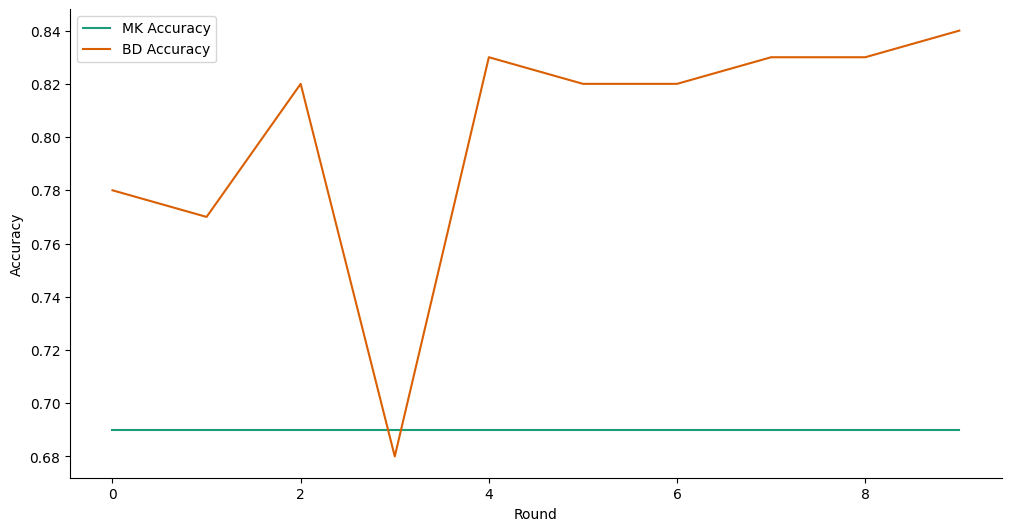

In [88]:
render_plot(title='Accuracy', series1_key='accuracy1', series2_key='accuracy2')

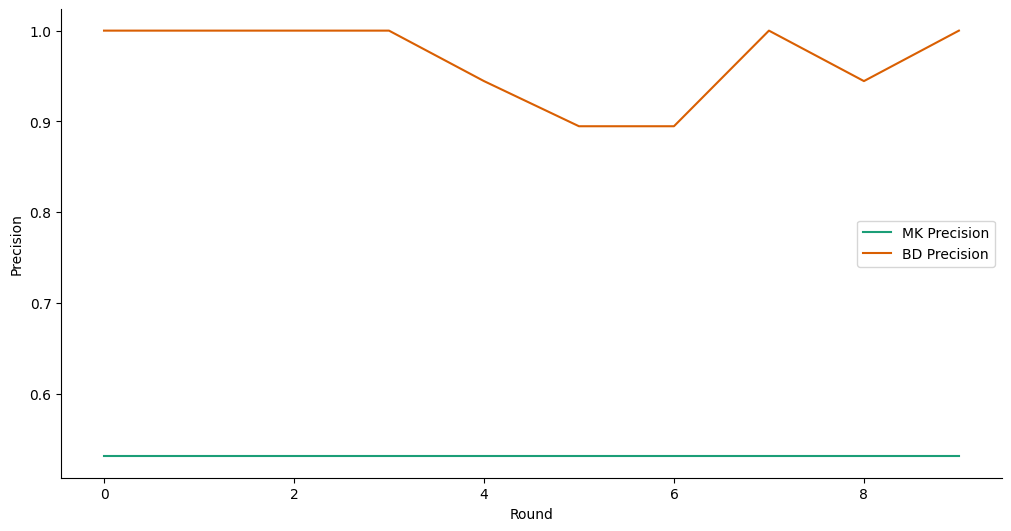

In [89]:
render_plot(title='Precision', series1_key='precision1', series2_key='precision2')

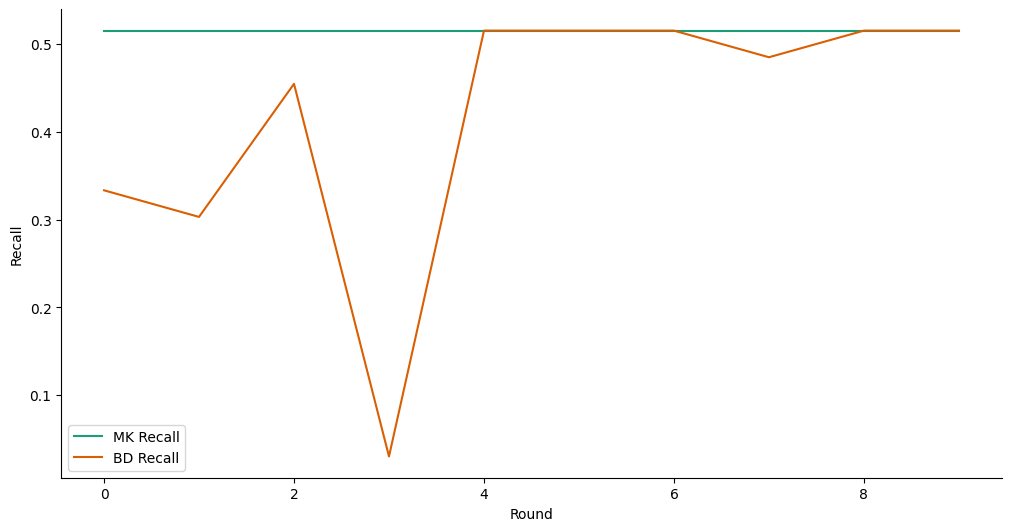

In [90]:
render_plot(title='Recall', series1_key='recall1', series2_key='recall2')

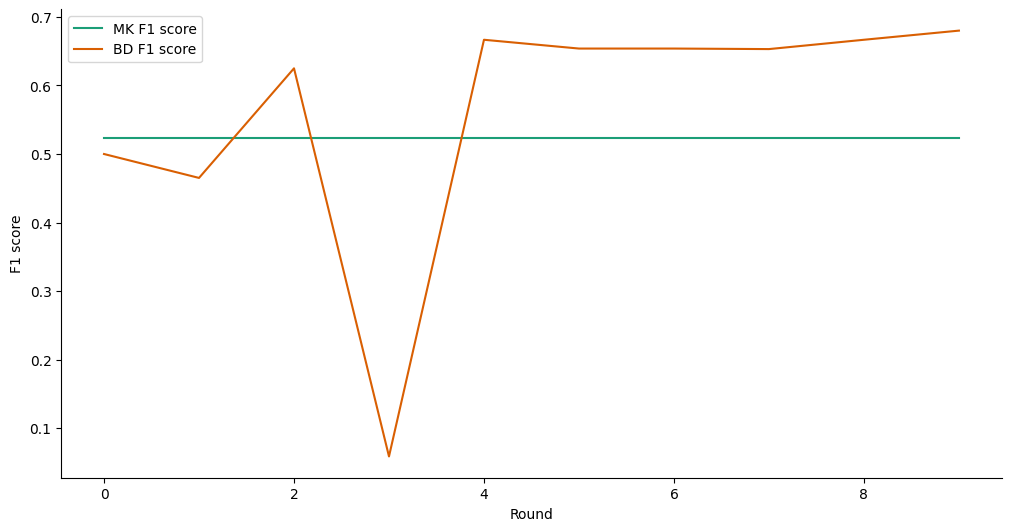

In [91]:
render_plot(title='F1 score', series1_key='f1_score1', series2_key='f1_score2')